In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import math
from skimage.metrics import structural_similarity, mean_squared_error

Загрузка и отображение исходного изображения

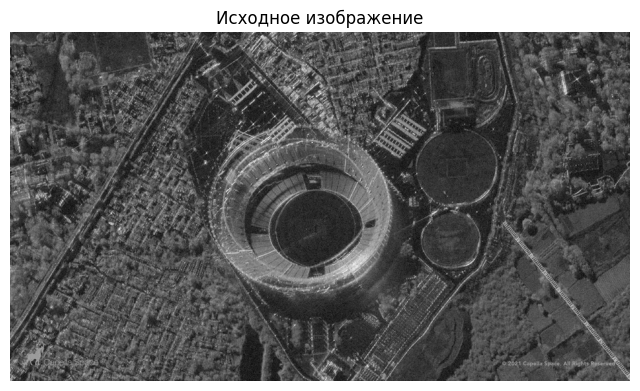

Размер изображения: (540, 960)


In [38]:
image = cv2.imread('assets/sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 6))
plt.imshow(image_gray, cmap="gray")
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

print(f"Размер изображения: {image_gray.shape}")

Генерация гауссовского шума

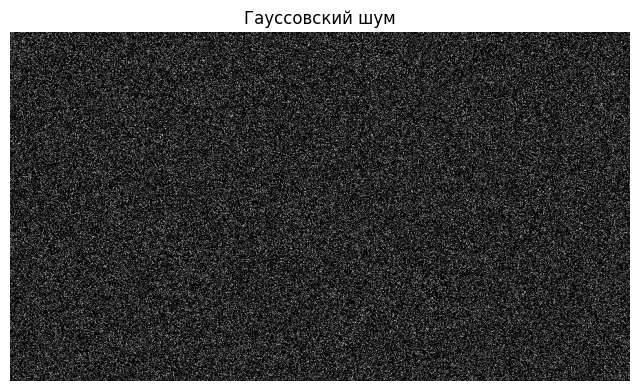

In [39]:
mean = 0
stddev = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)

plt.figure(figsize=(8, 6))
plt.imshow(noise_gauss, cmap="gray")
plt.title('Гауссовский шум')
plt.axis('off')
plt.show()

Генерация шума "соль и перец"

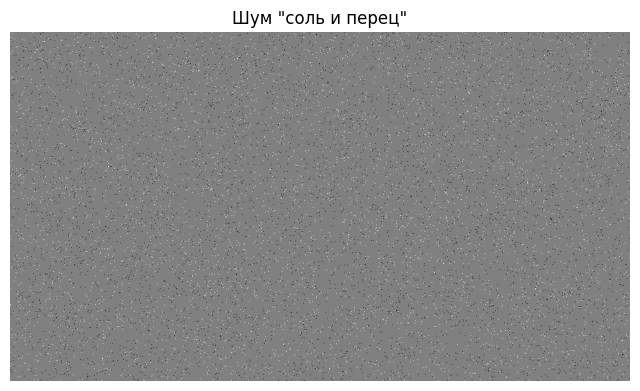

In [40]:
noise = np.random.randint(0, 101, size=(image_gray.shape[0], image_gray.shape[1]), dtype=int)
zeros_pixel = np.where(noise == 0)
ones_pixel = np.where(noise == 100)

bg_image = np.ones(image_gray.shape, np.uint8) * 128
bg_image[zeros_pixel] = 0
bg_image[ones_pixel] = 255

plt.figure(figsize=(8, 6))
plt.imshow(bg_image, cmap="gray")
plt.title('Шум "соль и перец"')
plt.axis('off')
plt.show()

Применение гауссовского шума к изображению

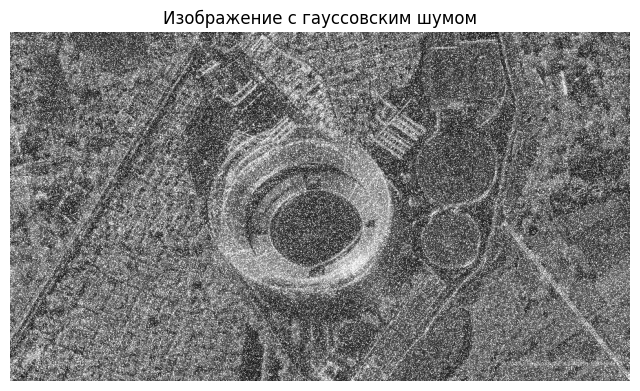

In [41]:
image_noise_gauss = cv2.add(image_gray, noise_gauss)

plt.figure(figsize=(8, 6))
plt.imshow(image_noise_gauss, cmap="gray")
plt.title('Изображение с гауссовским шумом')
plt.axis('off')
plt.show()

Расчет метрик для гауссовского шума

In [42]:
mse_gauss = mean_squared_error(image_gray, image_noise_gauss)
(ssim, diff) = structural_similarity(image_gray, image_noise_gauss, full=True)
print(f"Гауссовский шум: MSE = {mse_gauss:.4f}, SSIM = {ssim:.4f}")

Гауссовский шум: MSE = 4231.7661, SSIM = 0.1931


Применение шума "соль и перец" к изображению

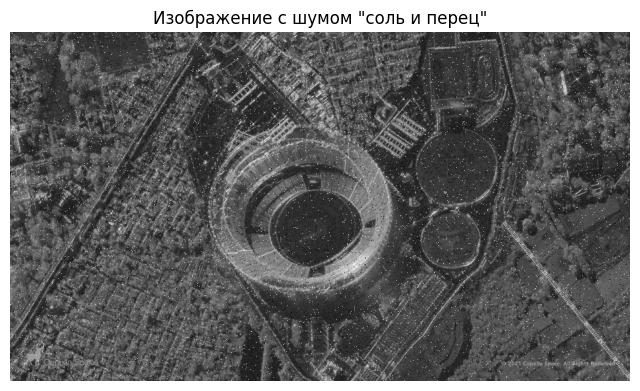

In [43]:
image_sp = copy.deepcopy(image_gray)
image_sp[zeros_pixel] = 0
image_sp[ones_pixel] = 255

plt.figure(figsize=(8, 6))
plt.imshow(image_sp, cmap="gray")
plt.title('Изображение с шумом "соль и перец"')
plt.axis('off')
plt.show()

Расчет метрик для шума "соль и перец"

In [44]:
mse_sp = mean_squared_error(image_gray, image_sp)
(ssim_sp, diff) = structural_similarity(image_gray, image_sp, full=True)
print(f"Шум соль и перец: MSE = {mse_sp:.4f}, SSIM = {ssim_sp:.4f}")

Шум соль и перец: MSE = 389.0314, SSIM = 0.7263


Применение фильтра Гаусса

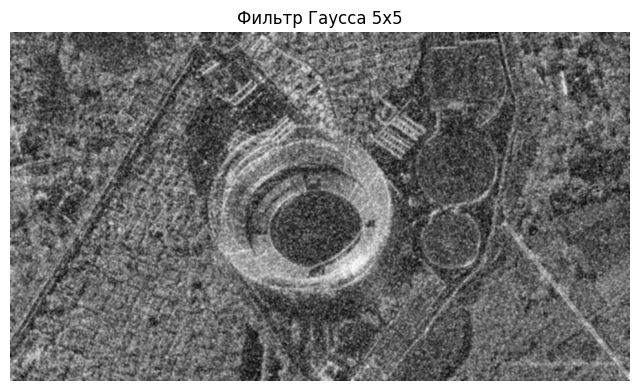

Фильтр Гаусса: MSE = 1775.8986, SSIM = 0.4856


In [45]:
image_gauss_gauss = cv2.GaussianBlur(image_noise_gauss, (5,5), 0)

plt.figure(figsize=(8, 6))
plt.imshow(image_gauss_gauss, cmap="gray")
plt.title('Фильтр Гаусса 5x5')
plt.axis('off')
plt.show()

mse_gauss_gauss = mean_squared_error(image_gray, image_gauss_gauss)
ssim_gauss_gauss = structural_similarity(image_gray, image_gauss_gauss)
print(f"Фильтр Гаусса: MSE = {mse_gauss_gauss:.4f}, SSIM = {ssim_gauss_gauss:.4f}")

Применение билатерального фильтра

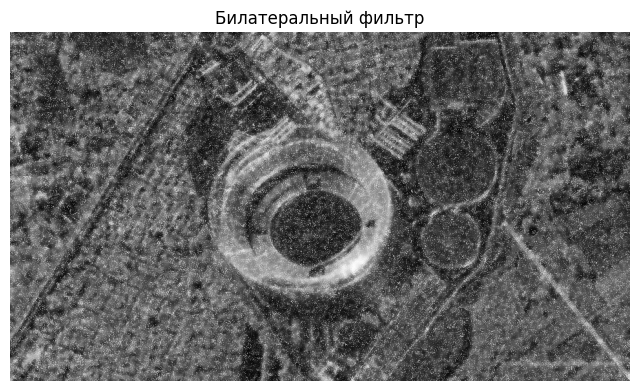

Билатеральный фильтр: MSE = 1849.1065, SSIM = 0.3174


In [46]:
image_gauss_bilat = cv2.bilateralFilter(image_noise_gauss, 9, 75, 75)

plt.figure(figsize=(8, 6))
plt.imshow(image_gauss_bilat, cmap="gray")
plt.title('Билатеральный фильтр')
plt.axis('off')
plt.show()

mse_bilat = mean_squared_error(image_gray, image_gauss_bilat)
ssim_bilat = structural_similarity(image_gray, image_gauss_bilat)
print(f"Билатеральный фильтр: MSE = {mse_bilat:.4f}, SSIM = {ssim_bilat:.4f}")

Применение NLM фильтра

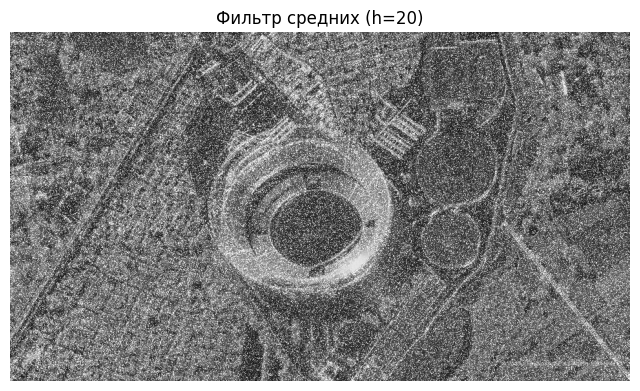

NLM h=20: MSE = 4227.3164, SSIM = 0.1935


In [47]:
image_gauss_nlm = cv2.fastNlMeansDenoising(image_noise_gauss, h=20)

plt.figure(figsize=(8, 6))
plt.imshow(image_gauss_nlm, cmap="gray")
plt.title('Фильтр средних (h=20)')
plt.axis('off')
plt.show()

mse_nlm = mean_squared_error(image_gray, image_gauss_nlm)
ssim_nlm = structural_similarity(image_gray, image_gauss_nlm)
print(f"NLM h=20: MSE = {mse_nlm:.4f}, SSIM = {ssim_nlm:.4f}")

Геометрический фильтр

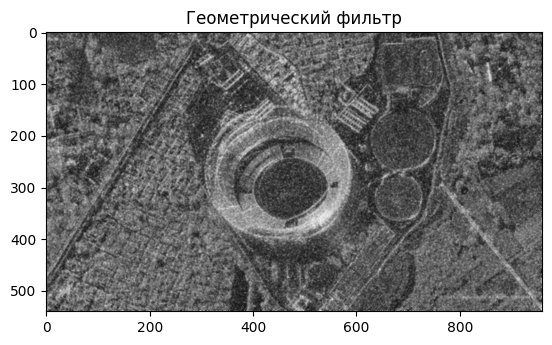

Геометрический фильтр: MSE = 1079.3958, SSIM = 0.5347


In [48]:
def geom(a):
    sum_log = 0
    for i in range(a.shape[0]):
        sum_log_row = 0
        for j in range(a.shape[1]):
            sum_log_row += math.log(a[i,j] + 1e-8)
        mean_log_row = sum_log_row / a.shape[1]
        sum_log += mean_log_row
    return math.exp(sum_log / a.shape[0])

def proc(img, filter):
    img_res = copy.deepcopy(img)
    for i in range(0, img.shape[0] - 2):
        for j in range(0, img.shape[1] - 2):
            img_res[i+1, j+1] = filter(img[i:i+3, j:j+3])
    return img_res

res = proc(image_noise_gauss, geom)

plt.figure(11)
plt.imshow(res, cmap="gray")
plt.title('Геометрический фильтр')
plt.show()

mse_geom = mean_squared_error(image_gray, res)
ssim_geom = structural_similarity(image_gray, res)
print(f"Геометрический фильтр: MSE = {mse_geom:.4f}, SSIM = {ssim_geom:.4f}")

Лапласиан фильтр

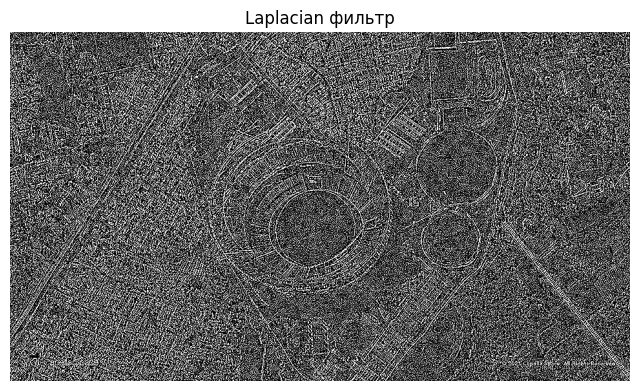

In [49]:
kernel_lapl = np.array([[0,-10,0], [-10,40,-10], [0,-10,0]], np.float32)
image_lapl = cv2.filter2D(image_gray, -1, kernel_lapl)

plt.figure(figsize=(8, 6))
plt.imshow(image_lapl, cmap="gray")
plt.title('Laplacian фильтр')
plt.axis('off')
plt.show()

Сравнение всех фильтров

In [50]:
print("СРАВНЕНИЕ ФИЛЬТРАЦИЙ ШУМА:")
results = [
    ("Исходный шум", mse_gauss, ssim),
    ("Фильтр Гаусса 5x5", mse_gauss_gauss, ssim_gauss_gauss),
    ("Билатеральный фильтр", mse_bilat, ssim_bilat),
    ("NLM h=20", mse_nlm, ssim_nlm),
    ("Геометрический фильтр", mse_geom, ssim_geom)
]

print("\nРезультаты всех фильтров:")
for name, mse, ssim_val in results:
    print(f"{name}: MSE = {mse:.4f}, SSIM = {ssim_val:.4f}")

results_sorted_ssim = sorted(results, key=lambda x: x[2], reverse=True)
results_sorted_mse = sorted(results, key=lambda x: x[1])

best_filter_ssim = results_sorted_ssim[0]
best_filter_mse = results_sorted_mse[0]

print(f"\nЛУЧШИЙ ФИЛЬТР ПО SSIM: {best_filter_ssim[0]} (SSIM = {best_filter_ssim[2]:.4f})")
print(f"ЛУЧШИЙ ФИЛЬТР ПО MSE: {best_filter_mse[0]} (MSE = {best_filter_mse[1]:.4f})")

СРАВНЕНИЕ ФИЛЬТРАЦИЙ ШУМА:

Результаты всех фильтров:
Исходный шум: MSE = 4231.7661, SSIM = 0.1931
Фильтр Гаусса 5x5: MSE = 1775.8986, SSIM = 0.4856
Билатеральный фильтр: MSE = 1849.1065, SSIM = 0.3174
NLM h=20: MSE = 4227.3164, SSIM = 0.1935
Геометрический фильтр: MSE = 1079.3958, SSIM = 0.5347

ЛУЧШИЙ ФИЛЬТР ПО SSIM: Геометрический фильтр (SSIM = 0.5347)
ЛУЧШИЙ ФИЛЬТР ПО MSE: Геометрический фильтр (MSE = 1079.3958)
